# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
sys.path.append('/home/andreas/data/coco/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader_train_val_test import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                    # resize both edges of the image to 224 accepting distortion
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""
transform_test = transforms.Compose([ 
    transforms.Resize((256)),                        # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

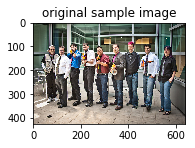

Image tensor shape:  torch.Size([1, 3, 224, 224])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.subplot(121)
plt.imshow(np.squeeze(orig_image))
plt.title('original sample image')
plt.show()

print("Image tensor shape: ", image.shape)

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

# Check for availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nDevice: ', device, '\n')


Device:  cuda 



Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-5_1.pkl'
decoder_file = 'decoder-5_1.pkl'
#encoder_file = 'encoder-10_2.pkl'
#decoder_file = 'decoder-10_2.pkl'

# TODO #3: Select appropriate values for the Python variables below.
#embed_size = 256
embed_size = 512
hidden_size = 512
num_lstm_layers = 1
#num_lstm_layers = 2

# Size of the trained vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval() # deactivate dropout
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_lstm_layers)
decoder.eval() # deactivate dropout
print('Initialize encoder and decoder models ...\n')

# Print encoder hyperparameters:
print('\n\nEncoderCNN hyperparameters:\n')
print('embed_size = ', embed_size)

# Print encoder structure
print('\n\nEncoderCNN structure:\n')
print(encoder)
print(' ')

# Print encoder hyperparameters
print('\n\nDecoderRNN hyperparameters:\n')
print('embed_size = ', embed_size)
print('hidden_size = ', hidden_size)
print('vocab_size = ', vocab_size)
print('num_layers = ', num_lstm_layers)

# Print decoder structure
print('\n\nDecoderRNN structure:\n')
print(decoder)
print(' ')

# Load the trained weights.
encoder_filepath = os.path.join('./models', encoder_file)
decoder_filepath = os.path.join('./models', decoder_file)
print('\n\nLoad encoder and decoder weights ...\n')
print('Load encoder weights from: {}'.format(encoder_filepath))
print('Load decoder weights from: {}'.format(decoder_filepath))
# Load state dictionaries of encoder and decoder mapping the location to the current device.
# This is necessary when the models have been saved on cuda but are loaded on cpu (if cuda is not available).
encoder.load_state_dict(torch.load(encoder_filepath, map_location=device))
decoder.load_state_dict(torch.load(decoder_filepath, map_location=device))
        
# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

# Print message
print('\n\nModels are ready for testing ...\n')

Initialize encoder and decoder models ...



EncoderCNN hyperparameters:

embed_size =  512


EncoderCNN structure:

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr



Models are ready for testing ...



<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Get index for the stop word from the vocabulary
# stop_idx = data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.end_word]

# Make sure to switch off gradients for more efficient processing
with torch.no_grad():
    # Obtain the embedded image features from the Image EncoderCNN and add another dimension for sequence length
    # Obtain features.shape = [batch_size, embed_size] => New feature.shape = [batch_size, seq_len, embed_size]
    features = encoder(image)
    
    # Pass the embedded image features through the model to get a predicted caption.
    # output = decoder.argmax_sample(features, stop_word=stop_idx)
    output_a = decoder.argmax_sample(features)
    output_b = decoder.beamsearch_sample(features, beam_size=9)
    print('example output (argmax):     ', output_a)
    print('example output (beam search):', output_b)

# Check output_a (argmax search)
assert (type(output_a)==list), "Output (A) needs to be a Python list" 
assert all([type(x)==int for x in output_a]), "Output(A) should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output_a]), \
    "Each entry in output (A) needs to correspond to an integer that indicates a token in the vocabulary."
# Check output_b (beam search)
assert (type(output_b)==list), "Output (B) needs to be a Python list" 
assert all([type(x)==int for x in output_b]), "Output (B) should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output_b]), \
    "Each entry in output (B) needs to correspond to an integer that indicates a token in the vocabulary."

example output (argmax):      [0, 3, 169, 6, 3, 91, 170, 364, 161, 72, 409, 18, 1]
example output (beam search): [0, 3, 60, 6, 20, 26, 13, 3, 80, 13, 51, 18, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
# TODO #4: Complete the function.
def clean_sentence(output):
    # Translate the numeric tokens of the predicted caption to words using idx2word dictionary from data loader
    # while removing the first word "<start>" and the last word "<end>"
    words = [data_loader.dataset.vocab.idx2word[idx] for idx in output][1:-1]
    # Join the translated words to form a caption sentence
    sentence = " ".join(words)
    # Capitalize first charactere in sentence
    sentence = sentence.capitalize()
    # Return caption sentence
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
# Sentence A predicted using argmax search
sentence_a = clean_sentence(output_a)
print('example sentence (argmax):     ', sentence_a)

assert type(sentence_a)==str, 'Sentence (A) needs to be a Python string!'

# Sentence B predicted using beam search
sentence_b = clean_sentence(output_b)
print('example sentence (beam search):', sentence_b)

assert type(sentence_b)==str, 'Sentence (B) needs to be a Python string!'

example sentence (argmax):      A man and a woman standing next to each other .
example sentence (beam search): A black and white photo of a group of people .


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [8]:
def get_prediction():
    # Get another original and transformed an normalized test image
    orig_image, image = next(iter(data_loader))
    # Show original test image
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    # Move transformed and normalized test image to the device
    image = image.to(device)
    # Get the embedded image features from the Encoder CNN
    features = encoder(image)
    # Get the predicted image caption from the Decoder RNN using argmax search
    output_a = decoder.argmax_sample(features) # use argmax
    # Translate word indices into words using the vocabulary from training dataset
    sentence_a = clean_sentence(output_a)
    print('Prediction using argmax search: ', sentence_a)
    # Get the predicted image caption from the Decoder RNN using beam search
    output_b = decoder.beamsearch_sample(features, beam_size=9) # use beam search
    # Translate word indices into words using the vocabulary from training dataset
    sentence_b = clean_sentence(output_b)
    print('Prediction using beam search:   ', sentence_b)

Run the code cell below (multiple times, if you like!) to test how this function works.

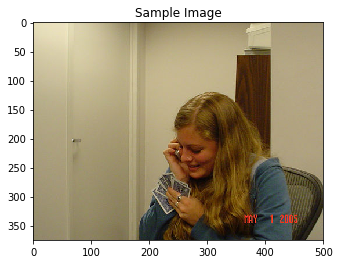

Prediction using argmax search:  A woman is holding a wii remote in her hand .
Prediction using beam search:    A woman taking a picture of herself in the mirror .


In [9]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

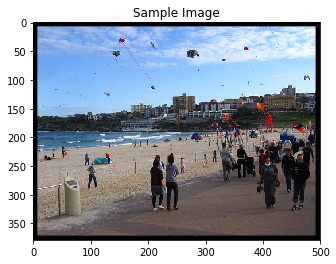

Prediction using argmax search:  A group of people standing on top of a beach .
Prediction using beam search:    A group of people standing on top of a sandy beach .


In [10]:
get_prediction()

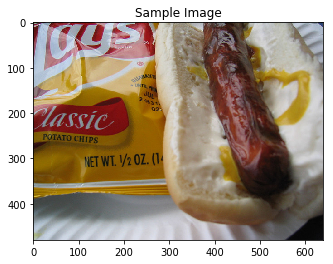

Prediction using argmax search:  A hot dog with mustard and ketchup on it .
Prediction using beam search:    A close up of a hot dog on a bun .


In [19]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

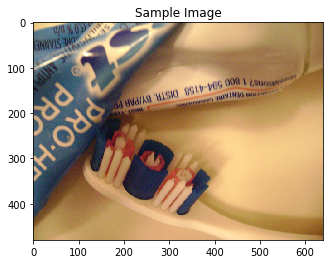

Prediction using argmax search:  A close up of a person holding a tooth brush
Prediction using beam search:    A close up of a pair of scissors .


In [11]:
get_prediction()

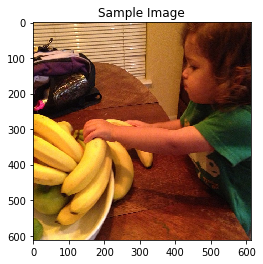

Prediction using argmax search:  A woman holding a donut in her hand .
Prediction using beam search:    There is a person holding a teddy bear .


In [20]:
get_prediction()

### Some more samples ...

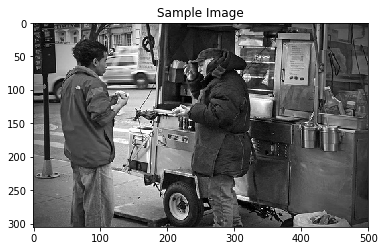

Prediction using argmax search:  A man standing in front of a store front .
Prediction using beam search:    A group of people that are posing for a picture .


In [12]:
get_prediction()

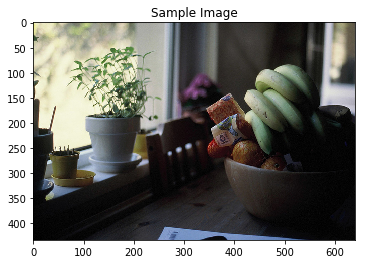

Prediction using argmax search:  A table with a plate of food and a drink
Prediction using beam search:    A wooden table topped with plates and bowls of food .


In [13]:
get_prediction()

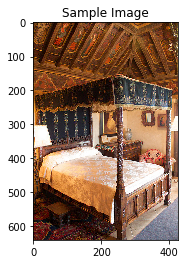

Prediction using argmax search:  A living room with a couch , chair , and a fireplace .
Prediction using beam search:    A living room filled with furniture and a flat screen tv .


In [14]:
get_prediction()

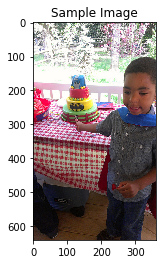

Prediction using argmax search:  A woman sitting on a couch with a laptop .
Prediction using beam search:    There is a woman sitting next to a suitcase


In [15]:
get_prediction()

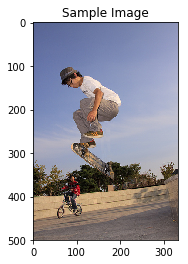

Prediction using argmax search:  A man riding a skateboard down a ramp .
Prediction using beam search:    A man riding a skateboard up the side of a ramp .


In [16]:
get_prediction()

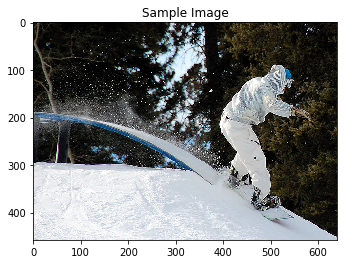

Prediction using argmax search:  A man riding a skateboard down a ramp .
Prediction using beam search:    A person on a skate board does a trick in the air .


In [17]:
get_prediction()

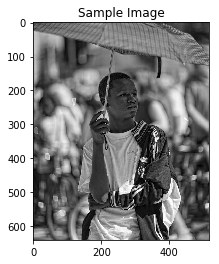

Prediction using argmax search:  A woman holding an umbrella and a man in a dress .
Prediction using beam search:    A group of people standing next to each other holding umbrellas .


In [18]:
get_prediction()

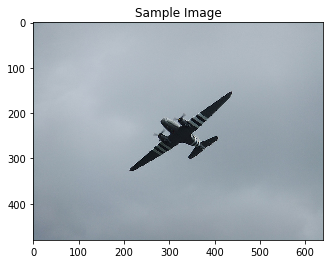

Prediction using argmax search:  A plane flying through the sky with a sky background
Prediction using beam search:    An airplane that is flying in the sky .


In [21]:
get_prediction()